## Self-RAG (자기 비판적 RAG)
- LLM의 직관을 믿지 않고, 정해진 검증 절차에 따라 스스로를 비판하며 최적의 답을 찾아가는 프로세스 
- Self-RAG의 3가지 검증 방식 
    1. Relevance: 검색된 지식이 질문에 대한 답을 품고 있는가? (품질 좋은 재료 확보)
    2. Groundedness: 답변에 쓰인 모든 문장이 문서 안에 근거가 있는가? (Hallucination 차단)
    3. Usefulness: 이 답변이 사용자의 가려운 곳을 긁어주는가? (최종 사용자 만족도)
- 장점: 답변의 신뢰도가 비약적으로 상승하며, 엉뚱한 문서를 들고 왔을 때 과감히 버리고 다시 검색할 수 있습니다.

### 1. Relevance Check (문서 관련성 검토)
- 검증 대상: 질문($Query$) vs 검색된 문서들($Documents$)
- 목적: "쓰레기 데이터가 들어오면 쓰레기 답변이 나간다(GIGO)"를 방지하는 단계입니다.
- LangGraph에서의 액션
    * Relevant: 통과! 답변 생성 노드로 이동합니다.
    * Irrelevant: 이 문서는 버립니다. 다시 검색하거나(Query Rewriting), 검색 원천을 바꾸는 루프로 돌아갑니다.
    
### 2. Hallucination Check (근거 기반 검토)
- 검증 대상: 생성된 답변($Generation$) vs 사용된 문서들($Documents$)
- 목적: LLM이 아는 척하며 지어내는 현상을 막는 단계입니다. 이를 보통 **Groundedness**라고도 부릅니다.
- LangGraph에서의 액션
    * Grounded: 답변이 문서 내용에 충실함. 최종 답변으로 확정합니다.
    * Hallucinated: LLM이 소설을 썼군요. 다시 답변을 생성하라고 시키거나, 1번 단계로 돌아가 다른 문서를 찾습니다.

### 3. Usefulness Check (답변 유용성 검토)
- 검증 대상: 생성된 답변($Generation$) vs 사용자 질문($Query$)
- 목적: 답변이 문서에 근거하더라도(Grounded), 실제로 사용자의 질문에 대한 실질적인 해답을 제공하는지 확인하여 "동문서답"을 방지합니다.
- LangGraph에서의 액션
    * Helpful: 통과! 사용자에게 최종 답변을 전달하고 프로세스를 종료($END$)합니다.
    * Unhelpful: 답변이 부족하거나 질문의 의도를 빗나갔습니다. 질문을 더 구체적으로 재작성($Query$ $Rewriting$)하여 처음부터 다시 검색($Retrieve$)하거나, 다른 검색 전략을 시도하는 루프로 돌아갑니다.

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model='text-embedding-3-large')

# 기존에 생성한 vector store 불러오기 
vector_store = Chroma(
    embedding_function=embeddings,
    collection_name = 'income_tax_collection',
    persist_directory = '../income_tax_collection' #로컬에 영구 저장 버전 
)

In [3]:
retriever = vector_store.as_retriever(search_kwargs={'k': 3})

In [ ]:
# State 정의 
from typing import Literal
from typing_extensions import List, TypedDict
from langchain_core.documents import Document

DOC_RELEVANCE_LITERAL = Literal["relevant", "irrelevant"]
HALLUCINATION_LITERAL = Literal["grounded", "hallucinated"]
HELPFULNESS_LITERAL = Literal["helpful", "unhelpful"] 

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

    # 검증 결과 
    doc_relevance_status: DOC_RELEVANCE_LITERAL
    hallucination_status: HALLUCINATION_LITERAL
    helpfulness_status: HELPFULNESS_LITERAL

    # 검증 시도 횟수 
    rewrite_count: int      # 질문 재작성 시도 횟수 (Max 3번)
    generation_count: int   # LLM 답변 생성 시도 횟수 (재생성 Max 2번)
    error_message: str

In [5]:
# Node 정의
from langchain_core.prompts import ChatPromptTemplate

# 사용자 query로 vector store에서 검색을 수행하는 노드 
def retrieve(state: AgentState) -> AgentState:
    query = state['query']
    
    docs = retriever.invoke(query)

    return {'context': docs}

In [6]:
from langchain_openai import ChatOpenAI
from langsmith import Client

llm = ChatOpenAI(model='gpt-4o')
client = Client()

In [7]:
# context와 query를 받아서 LLM 답변을 생성하는 노드 
def generate(state: AgentState) -> AgentState:
    context = state['context']
    query = state['query']
    
    prompt = client.pull_prompt("rlm/rag-prompt")
    rag_chain = prompt | llm
    response = rag_chain.invoke({'question': query, 'context': context})

    return {'answer': response.content, 'generation_count': state['generation_count'] + 1}

In [ ]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# 검색 결과의 정확도를 높이도록 사용자 쿼리를 변환하는 노드 
def rewrite(state: AgentState) -> AgentState:
    query = state['query']
    dictionary = ["사람을 나타내는 표현 -> 거주자"]

    keyword_dictionary_prompt = ChatPromptTemplate.from_template(
        f"""사용자의 질문을 보고, 키워드 사전을 참고해서 사용자의 질문을 변경해주세요. 
        사전: {dictionary}
        사용자의 질문: {{question}}
        """
    )
    keyword_dictionary_chain = keyword_dictionary_prompt| llm | StrOutputParser()
    rewritten_query = keyword_dictionary_chain.invoke({'question': query})

    return {'query': rewritten_query, 'rewrite_count': state['rewrite_count'] + 1}

In [9]:
validation_llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [ ]:
# retriver에서 검색한 문서의 관련성을 판단하는 노드 
def check_doc_relevance(state: AgentState):
    query = state['query'] 
    context = state['context'] 

    doc_relevance_prompt = client.pull_prompt("rlm/rag-document-relevance")

    doc_relevance_chain = doc_relevance_prompt | validation_llm

    response = doc_relevance_chain.invoke({
        "input": {
            "question": query,
            "documents": context
        }
    })
    
    # doc_relevance_chain의 결과: 문서 관련성이 높으면 1, 아니면 0 
    if response['Score'] == 1:
        return {"doc_relevance_status": "relevant"}
    else:
        return {"doc_relevance_status": "irrelevant"}

def get_doc_relevance_status(state: AgentState):
    if state['rewrite_count'] >= 3: #3번 이상 재작성 시도 시 종료
        return "count_limit"
    return state["doc_relevance_status"]

In [11]:
# 할루시네이션 검증 노드  
from langchain_core.prompts import PromptTemplate

def check_hallucination(state: AgentState):
    context = state["context"]
    answer = state["answer"]

    hallucination_prompt = PromptTemplate.from_template("""
        You are a teacher tasked with evaluating whether a student's answer is based on documents or not,
        Given documents, which are excepts from income tax law, and a student's answer;
        If the student's answer is based on documents, respond with "grounded",
        If the student's answer is not based on documents, respond with "hallucinated".

        documents: {documents}
        student_answer: {student_answer}
        """
    )

    hallucinations_chain = hallucination_prompt | validation_llm | StrOutputParser()
    
    # 평가 실행
    response = hallucinations_chain.invoke({
        "documents": context,
        "student_answer": answer 
    })

    # 판단 결과를 State에 업데이트합니다.
    return {"hallucination_status": response}

def get_hallucination_status(state: AgentState):
    if state['generation_count'] >= 3: # 2번이상 재작성시 종료 (초기 1번은 재작성이 아니므로 제외)
        return "count_limit"
    return state["hallucination_status"]

In [14]:
# 유용성 검증 노드 
from langgraph.graph import END

def check_helpfulness(state:AgentState):
    query = state['query']
    answer = state['answer']

    # Hub에서 검증된 프롬프트 가져오기
    helpfulness_prompt = client.pull_prompt("rlm/rag-answer-helpfulness")

    helpfulness_chain = helpfulness_prompt | validation_llm
    
    # 평가 실행
    response = helpfulness_chain.invoke({
        "input": {
            "question": query  
        },
        "output": answer 
    })
    
    score = response["Score"]
    if(score == 1):
        return {"helpfulness_status": "helpful"}
    else:
        return {"helpfulness_status": "unhelpful"}

def get_helpfulness_status(state: AgentState):
    if state['rewrite_count'] >= 3: #3번 이상 재작성 시도 시 종료
        return "count_limit"
    return state["helpfulness_status"]

In [ ]:
def inform_failure(state: AgentState) -> AgentState:
    return {
        "answer": "죄송합니다. 여러 번의 재시도에도 불구하고 정확하고 유용한 답변을 생성하는 데 실패했습니다. 질문을 조금 더 구체적으로 바꿔보시겠어요?"
    }

In [ ]:
from langgraph.graph import StateGraph, START, END

#  그래프 빌더 생성 
graph_builder = StateGraph(AgentState)

# 노드 추가 
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("rewrite", rewrite)
graph_builder.add_node("check_doc_relevance", check_doc_relevance)
graph_builder.add_node("check_hallucination", check_hallucination)
graph_builder.add_node("check_helpfulness", check_helpfulness)
graph_builder.add_node("inform_failure", inform_failure)

In [ ]:
from langgraph.graph import StateGraph, START, END
# 엣지 추가 
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("retrieve", "check_doc_relevance")
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge("generate", "check_hallucination")
graph_builder.add_edge("inform_failure", END)

graph_builder.add_conditional_edges(
    "check_doc_relevance",
    get_doc_relevance_status,
    {
        "relevant": "generate",
        "irrelevant": "rewrite",
        "count_limit": "inform_failure"
     }
)

graph_builder.add_conditional_edges(
    "check_hallucination",
    get_hallucination_status,
    {
        "grounded": "check_helpfulness",
        "hallucinated": "generate",
        "count_limit": "inform_failure"
    }
)

graph_builder.add_conditional_edges(
    "check_helpfulness",
    get_helpfulness_status,
    {
        "helpful": END,
        "unhelpful": "rewrite",
        "count_limit": "inform_failure"
    }
)

In [20]:
# 그래프 생성 
graph = graph_builder.compile() 

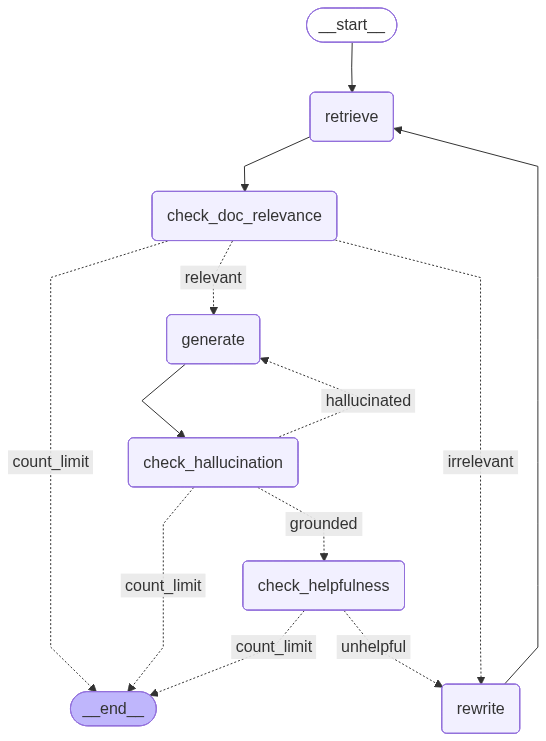

In [21]:
# 그래프 시각화 
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# 그래프 실행 
initial_state = {'query': '연봉 5천만원 세금', 'generation_count': 0, 'rewrite_count': 0} #초기값 0
result = graph.invoke(initial_state)

print(result['answer'])

{'query': '사용자의 질문: 연봉 5천만원 거주자 세금',
 'context': [Document(id='587bb229-bf18-4b44-b8e0-5225e00aeaad', metadata={'source': '../documents/income_tax.txt'}, page_content='5년 이하: 30만원 → 납입연수\n5년 초과 10년 이하: 150만원 + 50만원 × (납입연수 - 5년)\n10년 초과 20년 이하: 400만원 + 80만원 × (납입연수 - 10년)\n20년 초과: 1,200만원 + 120만원 × (납입연수 - 20년)\n\n② 직장근로자 초과관세환급금을 분배하여 지급받는 경우 세액의 계산 방법 등 필요한 사항은 대통령령으로 정한다. \n<대통령 2014. 12. 23.>\n<전문개정 2009. 12. 31.>\n제64조(부동산매매업자에 대한 세액 계산의 특례)\n1) 대통령령으로 정하는 부동산매매업(이하 “부동산매매업”이라 한다)을 영위하는 거주자가 이하 “부동산매매업자”라 한다)로서 종합소득세법에 제104조제1항제1호(본항을 포함한다) 및 제103조 또는 같은 조 제7항 각 호의 어느 하나에 해당하는 자산의 매매자익(이하 “주택등매매차익”이라 한다)이 있는 자의 종합소득 산출세액은 다음 각 호의 세액 중 많은 것으로 한다. \n<개정 2014. 12. 23., 2017. 12. 19., 2020. 12. 29.>\n1. 종합소득 산출세액\n\n다음 각 목에 따른 세액의 합계액\n  가. 주택등매매차익에 따른 세율을 적용하여 산출한 세액의 합계액\n  나. 종합소득세법 제55조에 따라 주택등매매차익에 대한 개별세액을 공제한 금액을 과세표준으로 하고 이에 제55조에 따른 세율을 적용하여 산출세액'),
  Document(id='7b33c9ac-2ce1-4711-bcc5-566f0486a63d', metadata={'source': '../documents/income_tax.txt'}, page_content='② 제70조제1